# 用户购买预测使用paddlerec的baseline
$\color{red}{Tips：该部分主要为介绍思路和paddlerec构建基线模型}$
## 赛题介绍
智能营销工具可以帮助商家预测用户购买的行为，本次比赛提供了一份品牌商家的历史订单数据，参赛选手需构建一个预测模型，预估用户人群在规定时间内产生购买行为的概率。
该模型可应用于各种电商数据分析，以及百度电商开放平台， 不仅可以帮助商家基于平台流量，进行商品售卖、支付，还可以通过MarTech技术更精准地锁定核心用户，对用户的购买行为进行预测。

- $\color{red}{特别注意：数据进行了模拟生成，对某些特征含义进行了隐藏，并进行了脱敏处理}$

- $\color{red}{特别注意：本次比赛需要选手使用环境：飞桨PaddlePaddle>=1.7.2 , PaddleRec>=0.1以及以上版本参赛}$

- $\color{red}{特别注意：AI Studio上运行需要使用32G内存的高级版，本地运行同样需要配置较大的内存空间。}$

[点击跳转至赛题页面](https://aistudio.baidu.com/aistudio/competition/detail/51)

## 基线介绍
### 运行方式

本次基线基于飞桨PaddlePaddle1.8，PaddleRec v1.8.5版本，若本地运行则可能需要额外安装jupyter notebook环境、pandas模块等。  


#### AI Studio (Notebook)运行

依次运行下方的cell即可，若运行时修改了cell，推荐在右上角重启执行器后再以此运行，避免因内存未清空而产生报错。

#### 本地运行

fork本项目后点击右上角的“文件”——“导出Notebook为ipynb”，下载到本地后在`jupyter notebook`环境即可开始训练，生成的推理结果文件为`submission.csv`。

### 设计思想

#### 执行流程

1. 配置预处理数据方案
3. 开始训练
4. 执行预测并产生结果文件

#### 技术方案
在本次赛题中，虽然赛题是一个二分类任务（用户购买、未购买），但从赛题数据看，属于比较典型的时间序列数据，也可以参照以往的线性回归任务的做法处理。 
接下来将介绍技术方案中的一些细节问题以及method流程。

##### label设计
本次赛题反映了一个客观事实——在真实场景应用机器学习/深度学习技术时，通常是没有已经整理好的训练集、验证集、测试集，需要自己设计。

比如赛题中提到，在比赛任务是预测下个月用户是否购买，下个月是哪个月？我们不妨设想自己是个业务经理，现在领导说做个模型，预测下个月你手上的客户是否会流失。所以在这类题目中，下个月就是提供的数据集截止日期之后的一个月。当然，如果比赛要求预测未来7天、未来15天的销售情况，道理也是一样的。

在此类比赛的解决方案中，通常会有个时间滑窗的概念。比如按月进行时间滑窗，本题中数据到2013.8.31，默认提供的数据集划分设计如下（选手也可以自行设计数据集的划分）：
- 训练集：选择某一天为截止时间，用截止时间前的3个月预测用户截止时间后的一个月是否购买；（保证截止时间后还存在一个月的数据）
- 验证集：选择某一天为截止时间，用截止时间前的3个月预测用户截止时间后的一个月是否购买；（保证截止时间后还存在一个月的数据）
- 测试集：用2013年6-8月的数据预测用户在9月是否购买（其实就是预测的目标）

```python
# 这是一个时间滑窗函数，获得dt之前minus天以来periods的dataframe，以便进一步计算
def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]
```

##### 时间滑窗特征构建
> 注：更详细的时间滑窗特征工程的方法请参考[用户购买预测时间滑窗特征构建](https://aistudio.baidu.com/aistudio/projectdetail/276829)，本项目做了大幅缩减。

时间滑窗在业务应用上被称为RFM模型，RFM模型最早是用来衡量客户价值和客户创利能力。理解RFM框架的思想是构造统计类特征的基础，其含义为：
- R（Recency）：客户最近一次交易消费时间的间隔。R值越大，表示客户交易发生的日期越久，反之则表示客户交易发生的日期越近。
- F（Frequency）：客户在最近一段时间内交易消费的次数。F值越大，表示客户交易越频繁，反之则表示客户交易不够活跃。
- M（Monetary）：客户在最近一段时间内交易消费的金额。M值越大，表示客户价值越高，反之则表示客户价值越低。

也就是说，时间滑窗特征本身是与业务紧密联系的，而在这类时间序列数据的比赛中，滑动时间窗口内的统计指标可以更加丰富，统计值一般会有最大值、最小值、均值、标准差、中位数、极差等。

```python
# 要计算统计指标特征的时间窗口
for i in [14,30,60,91]:
	tmp = get_timespan(df_payment, t2018, i, i)
   # 削去峰值的均值特征
   X['mean_%s_decay' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
   # 中位数特征，在本赛题中基本不适用
   # X['median_%s' % i] = tmp.median(axis=1).values
   # 最小值特征，在本赛题中基本不适用
   # X['min_%s' % i] = tmp_1.min(axis=1).values
   # 最大值特征
   X['max_%s' % i] = tmp.max(axis=1).values
   # 标准差特征
   # X['std_%s' % i] = tmp_1.std(axis=1).values
   # 求和特征
   X['sum_%s' % i] = tmp.sum(axis=1).values
```
##### 深度学习模型搭建
参考[十分钟！全流程！从零搭建推荐系统](https://aistudio.baidu.com/aistudio/projectdetail/559336)和[乘风破浪的调参侠！玩转特征重要性～从此精通LR](https://aistudio.baidu.com/aistudio/projectdetail/618918)搭建三层深度神经网络。需要注意的是，由于神经网络对缺失值和稀疏数据敏感，对送入神经网络的特征需要做筛选。另外，选择哪种神经网络结构效果更好，需要参赛选手进一步探索。
```python
# 构建多层神经网络
def net(self, input, is_infer=False):
        self.data_inputs = input[0]
        self.label_input = input[1]

        fc1 = fluid.layers.fc(input = self.data_inputs,size = self.fc1_size ,act='relu')
        fc2 = fluid.layers.fc(input = fc1 ,size = self.fc2_size ,act='relu')
        predict = fluid.layers.fc(input = fc2 ,size=2,act='softmax')
        self.predict = predict

        auc, batch_auc, _ = fluid.layers.auc(input=self.predict,
                                             label=self.label_input,
                                             num_thresholds=2**12,
                                             slide_steps=20)
        if is_infer:
            self._infer_results["AUC"] = auc
            self._infer_results["BATCH_AUC"] = batch_auc
            return

        self._metrics["AUC"] = auc
        self._metrics["BATCH_AUC"] = batch_auc
        cost = fluid.layers.cross_entropy(
            input=self.predict, label=self.label_input)
        avg_cost = fluid.layers.reduce_mean(cost)
        self._cost = avg_cost
```

## 数据预处理 - 数据集划分与特征工程

In [1]:
import numpy as np  #
import pandas as pd  #
from datetime import datetime, date, timedelta
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
# from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV,Ridge,Lasso,ElasticNet
# from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor,RandomForestClassifier
# from sklearn.feature_selection import mutual_info_regression
# from sklearn.svm import SVR, LinearSVC
# from sklearn.pipeline import make_pipeline,Pipeline
# from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler,MinMaxScaler
# from sklearn.model_selection import KFold, cross_val_score, train_test_split
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import train_test_split
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import time
from itertools import product
import datetime as dt
import calendar
import gc
from datetime import date, timedelta
import paddle
import paddle.fluid as fluid
import paddle.fluid.dygraph as dygraph
from paddle.fluid.dygraph import Linear
import random

### 加载数据集

In [2]:
PATH = './data/data19383/'
train = pd.read_csv(PATH + 'train.csv')
# train = pd.read_csv('./data/data19383/train.csv', usecols=[2, 3, 4, 6, 7, 18])
# set index to ID to avoid droping it later
# 把测试集的id列作为索引，防止误删
test  = pd.read_csv(PATH + 'submission.csv').set_index('customer_id')

In [3]:
# 训练集概况
train[['order_detail_id','order_id','order_amount','order_pay_time','is_customer_rate','order_detail_goods_num','order_detail_amount','order_detail_discount','customer_id','goods_id']].tail(10)

,order_detail_id,order_id,order_amount,order_pay_time,is_customer_rate,order_detail_goods_num,order_detail_amount,order_detail_discount,customer_id,goods_id
2306861,3685490,3238357,707.7,2013-01-24 00:24:40,0.0,2.0,179.8,298.2,2826572,1478
2306862,3685491,3238356,775.9,2012-11-11 17:35:05,0.0,1.0,126.9,172.1,2826572,2103
2306863,3685492,3238357,707.7,2013-01-24 00:24:40,0.0,1.0,0.0,29.9,2826572,3153
2306864,3685493,3238356,775.9,2012-11-11 17:35:05,0.0,1.0,74.9,105.0,2826572,1778
2306865,3685494,3238357,707.7,2013-01-24 00:24:40,0.0,1.0,94.9,104.9,2826572,2128
2306866,3685495,3238358,199.0,2013-01-10 19:24:31,0.0,1.0,59.9,139.1,2826573,1173
2306867,3685496,3238359,299.8,2013-01-27 15:00:27,0.0,1.0,0.0,59.9,2826574,2513
2306868,3685497,3238359,299.8,2013-01-27 15:00:27,0.0,1.0,89.9,150.0,2826574,998
2306869,3685498,3238360,168.0,2012-11-11 00:10:37,0.0,1.0,76.9,91.1,2826574,1423
2306870,3685499,3238361,102.0,2013-07-10 14:22:14,0.0,1.0,49.9,52.1,2826574,1043


In [4]:
len(test)

1585986

In [5]:
len(train['customer_id'][train.order_pay_time>'2013-07-31'].unique())

174770

In [6]:
len(train[train.order_pay_time<'2013-07-31'])

2078390

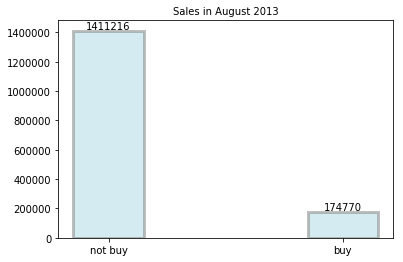

In [7]:
%matplotlib inline
y = range(1,2)
 
plt.bar(['not buy','buy'], [1585986-174770,174770], alpha=0.5, width=0.3, color='lightblue', edgecolor='grey', lw=3)
plt.title('Sales in August 2013', fontsize=10)
for a, b in zip(['not buy','buy'], [1585986-174770,174770]):
    plt.text(a, b + 0.05, '%.0f' % b, ha='center', va='bottom', fontsize=10)
plt.show()

In [8]:
# 对于特别大的文件，我们需要做一些内存检查
mem_train = train.memory_usage(index=True).sum()
mem_test=test.memory_usage(index=True).sum()
print(u"训练集使用内容 "+ str(mem_train/ 1024**2)+" MB")
print(u"测试集使用内存 "+ str(mem_test/ 1024**2)+" MB")

训练集使用内容 510.40096282958984 MB
测试集使用内存 24.200225830078125 MB


### 内存优化脚本
- 参考[缓解pandas中DataFrame占用内存过大的问题](https://blog.csdn.net/wj1066/article/details/81124959)
- 效果非常显著，有效避免内存溢出

In [9]:
# @from: https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65/code
# @liscense: Apache 2.0
# @author: weijian
def reduce_mem_usage(props):
    # 计算当前内存
    start_mem_usg = props.memory_usage().sum() / 1024 ** 2
    print("Memory usage of the dataframe is :", start_mem_usg, "MB")
    
    # 哪些列包含空值，空值用-999填充。why：因为np.nan当做float处理
    NAlist = []
    for col in props.columns:
        # 这里只过滤了objectd格式，如果你的代码中还包含其他类型，请一并过滤
        if (props[col].dtypes != object):
            
            # print("**************************")
            # print("columns: ", col)
            # print("dtype before", props[col].dtype)
            
            # 判断是否是int类型
            isInt = False
            mmax = props[col].max()
            mmin = props[col].min()
            
            # Integer does not support NA, therefore Na needs to be filled
            if not np.isfinite(props[col]).all():
                NAlist.append(col)
                props[col].fillna(-999, inplace=True) # 用-999填充
                
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = np.fabs(props[col] - asint)
            result = result.sum()
            if result < 0.01: # 绝对误差和小于0.01认为可以转换的，要根据task修改
                isInt = True
            
            # make interger / unsigned Integer datatypes
            if isInt:
                if mmin >= 0: # 最小值大于0，转换成无符号整型
                    if mmax <= 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mmax <= 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mmax <= 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else: # 转换成有符号整型
                    if mmin > np.iinfo(np.int8).min and mmax < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mmin > np.iinfo(np.int16).min and mmax < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mmin > np.iinfo(np.int32).min and mmax < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mmin > np.iinfo(np.int64).min and mmax < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)  
            else: # 注意：这里对于float都转换成float16，需要根据你的情况自己更改
                props[col] = props[col].astype(np.float16)
            
            # print("dtype after", props[col].dtype)
            # print("********************************")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [10]:
# 处理id字段
train['order_detail_id'] = train['order_detail_id'].astype(np.uint32)
train['order_id'] = train['order_id'].astype(np.uint32)
train['customer_id'] = train['customer_id'].astype(np.uint32)
train['goods_id'] = train['goods_id'].astype(np.uint32)
train['goods_class_id'] = train['goods_class_id'].astype(np.uint32)
train['member_id'] = train['member_id'].astype(np.uint32)
# 处理状态字段，这里同时处理空值，将空值置为0
train['order_status'] = train['order_status'].astype(np.uint8)
train['goods_has_discount'] = train['goods_has_discount'].astype(np.uint8)
train["is_member_actived"].fillna(0, inplace=True)
train["is_member_actived"]=train["is_member_actived"].astype(np.int8)
train["member_status"].fillna(0, inplace=True)
train["member_status"]=train["member_status"].astype(np.int8)
train["customer_gender"].fillna(0, inplace=True)
train["customer_gender"]=train["customer_gender"].astype(np.int8)
train['is_customer_rate'] = train['is_customer_rate'].astype(np.uint8)
train['order_detail_status'] = train['order_detail_status'].astype(np.uint8)
# 处理日期
train['goods_list_time']=pd.to_datetime(train['goods_list_time'],format="%Y-%m-%d")
train['order_pay_time']=pd.to_datetime(train['order_pay_time'],format="%Y-%m-%d")
train['goods_delist_time']=pd.to_datetime(train['goods_delist_time'],format="%Y-%m-%d")
# 检查内存使用
mem_train = train.memory_usage(index=True).sum()
mem_test=test.memory_usage(index=True).sum()
print(u"训练集使用内容 "+ str(mem_train/ 1024**2)+" MB")
print(u"测试集使用内存 "+ str(mem_test/ 1024**2)+" MB")

训练集使用内容 349.8006982803345 MB
测试集使用内存 24.200225830078125 MB


### 构造时间滑窗特征

#### 每日付款金额

In [11]:
# 将用户下单金额按天进行汇总
# df = train[train.order_status<101][train.order_pay_time>'2013-02-01']
df = train[train.order_pay_time>'2013-02-01']
df['date'] = pd.DatetimeIndex(df['order_pay_time']).date
df_payment = df[['customer_id','date','order_total_payment']]

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [12]:
len(df_payment['customer_id'].unique())

685471

注意，成功交易的客户数量不等于全部客户数量，说明有相当一部分客户虽然下过单，但是没有成功的订单，那么这些客户自然应当算在训练集之外。
数据合并时，由于`test.csv`中，已经设置了默认0值，只需要和训练后的预测标签做一个`left join`就可以了

In [13]:
df_payment = df_payment.groupby(['date','customer_id']).agg({'order_total_payment': ['sum']})
df_payment.columns = ['day_total_payment']
df_payment.reset_index(inplace=True)

In [14]:
df_payment = df_payment.set_index(
    ["customer_id", "date"])[["day_total_payment"]].unstack(level=-1).fillna(0)
df_payment.columns = df_payment.columns.get_level_values(1)

#### 每日购买商品数量

In [15]:
df_goods = df[['customer_id','date','order_total_num']]
df_goods = df_goods.groupby(['date','customer_id']).agg({'order_total_num': ['sum']})
df_goods.columns = ['day_total_num']
df_goods.reset_index(inplace=True)
df_goods = df_goods.set_index(
    ["customer_id", "date"])[["day_total_num"]].unstack(level=-1).fillna(0)
df_goods.columns = df_goods.columns.get_level_values(1)

该场景每天都有成交记录，这样就不需要考虑生成完整时间段填充的问题

In [16]:
# 这是一个时间滑窗函数，获得dt之前minus天以来periods的dataframe，以便进一步计算
def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

1. 构造dataset这里有个取巧的地方，因为要预测的9月份除了开学季以外不是非常特殊的月份，因此主要考虑近期的因素，数据集的开始时间也是2月1日，尽量避免了双十一、元旦假期的影响，当然春节假期继续保留。同时，构造数据集的时候保留了customer_id，主要为了与其它特征做整合。
2. 通过一个函数整合付款金额和商品数量的时间滑窗，主要是因为分开做到时候合并占用内存更大，并且函数最后在返回值处做了内存优化，用时间代价尽可能避免内存溢出。

In [17]:
def prepare_dataset(df_payment, df_goods, t2018, is_train=True):
    X = {}
    # 整合用户id
    tmp = df_payment.reset_index()
    X['customer_id'] = tmp['customer_id']
    # 消费特征
    print('Preparing payment feature...')
    for i in [14,30,60,91]:
        tmp = get_timespan(df_payment, t2018, i, i)
        # X['diff_%s_mean' % i] = tmp_1.diff(axis=1).mean(axis=1).values
        X['mean_%s_decay' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        # X['mean_%s' % i] = tmp_1.mean(axis=1).values
        # X['median_%s' % i] = tmp.median(axis=1).values
        # X['min_%s' % i] = tmp_1.min(axis=1).values
        X['max_%s' % i] = tmp.max(axis=1).values
        # X['std_%s' % i] = tmp_1.std(axis=1).values
        X['sum_%s' % i] = tmp.sum(axis=1).values
    for i in [14,30,60,91]:
        tmp = get_timespan(df_payment, t2018 + timedelta(days=-7), i, i)
        X['mean_%s_decay_2' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        # X['mean_%s_2' % i] = tmp_2.mean(axis=1).values
        # X['median_%s_2' % i] = tmp.median(axis=1).values
        # X['min_%s_2' % i] = tmp_2.min(axis=1).values
        X['max_%s_2' % i] = tmp.max(axis=1).values
        # X['std_%s_2' % i] = tmp_2.std(axis=1).values
    for i in [14,30,60,91]:
        tmp = get_timespan(df_payment, t2018, i, i)
        X['has_sales_days_in_last_%s' % i] = (tmp != 0).sum(axis=1).values
        X['last_has_sales_day_in_last_%s' % i] = i - ((tmp != 0) * np.arange(i)).max(axis=1).values
        X['first_has_sales_day_in_last_%s' % i] = ((tmp != 0) * np.arange(i, 0, -1)).max(axis=1).values

    # 对此处进行微调，主要考虑近期因素
    for i in range(1, 4):
        X['day_%s_2018' % i] = get_timespan(df_payment, t2018, i*30, 30).sum(axis=1).values
    # 商品数量特征，这里故意把时间和消费特征错开，提高时间滑窗的覆盖面
    print('Preparing num feature...')
    for i in [21,49,84]:
            tmp = get_timespan(df_goods, t2018, i, i)
            # X['goods_diff_%s_mean' % i] = tmp_1.diff(axis=1).mean(axis=1).values
            # X['goods_mean_%s_decay' % i] = (tmp_1 * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
            X['goods_mean_%s' % i] = tmp.mean(axis=1).values
            # X['goods_median_%s' % i] = tmp.median(axis=1).values
            # X['goods_min_%s' % i] = tmp_1.min(axis=1).values
            X['goods_max_%s' % i] = tmp.max(axis=1).values
            # X['goods_std_%s' % i] = tmp_1.std(axis=1).values
            X['goods_sum_%s' % i] = tmp.sum(axis=1).values
    for i in [21,49,84]:    
            tmp = get_timespan(df_goods, t2018 + timedelta(weeks=-1), i, i)
            # X['goods_diff_%s_mean_2' % i] = tmp_2.diff(axis=1).mean(axis=1).values
            # X['goods_mean_%s_decay_2' % i] = (tmp_2 * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
            X['goods_mean_%s_2' % i] = tmp.mean(axis=1).values
            # X['goods_median_%s_2' % i] = tmp.median(axis=1).values
            # X['goods_min_%s_2' % i] = tmp_2.min(axis=1).values
            X['goods_max_%s_2' % i] = tmp.max(axis=1).values
            X['goods_sum_%s_2' % i] = tmp.sum(axis=1).values
    for i in [21,49,84]:    
            tmp = get_timespan(df_goods, t2018, i, i)
            X['goods_has_sales_days_in_last_%s' % i] = (tmp > 0).sum(axis=1).values
            X['goods_last_has_sales_day_in_last_%s' % i] = i - ((tmp > 0) * np.arange(i)).max(axis=1).values
            X['goods_first_has_sales_day_in_last_%s' % i] = ((tmp > 0) * np.arange(i, 0, -1)).max(axis=1).values


    # 对此处进行微调，主要考虑近期因素
    for i in range(1, 4):
        X['goods_day_%s_2018' % i] = get_timespan(df_goods, t2018, i*28, 28).sum(axis=1).values

    X = pd.DataFrame(X)
    
    reduce_mem_usage(X)
    
    if is_train:
        # 这样转换之后，打标签直接用numpy切片就可以了
        # 当然这里前提是确认付款总额没有负数的问题
        X['label'] = df_goods[pd.date_range(t2018, periods=30)].max(axis=1).values
        X['label'][X['label'] > 0] = 1
        return X
    return X

In [18]:
num_days = 4
t2017 = date(2013, 7, 1)
X_l, y_l = [], []
for i in range(num_days):
    delta = timedelta(days=7 * i)
    # X_tmp, y_tmp = prepare_dataset(df_payment, df_goods, t2017 + delta)
    X_tmp = prepare_dataset(df_payment, df_goods, t2017 + delta)
    X_tmp = pd.concat([X_tmp], axis=1)

    X_l.append(X_tmp)
    # y_l.append(y_tmp)

X_train = pd.concat(X_l, axis=0)
# y_train = np.concatenate(y_l, axis=0)

del X_l, y_l

Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 345.16221618652344 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  73.87003993988037  MB
This is  21.401542948710667 % of the initial size


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 345.16221618652344 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  73.87003993988037  MB
This is  21.401542948710667 % of the initial size


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 345.16221618652344 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  73.87003993988037  MB
This is  21.401542948710667 % of the initial size


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 345.16221618652344 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  73.87003993988037  MB
This is  21.401542948710667 % of the initial size


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
X_test = prepare_dataset(df_payment, df_goods, date(2013, 9, 1), is_train=False)
X_test = pd.concat([X_test], axis=1)

Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 345.16221618652344 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  73.87003993988037  MB
This is  21.401542948710667 % of the initial size


### 中间结果保存

In [20]:
X_train.to_csv('X_train.csv')

In [21]:
X_test.to_csv('X_test.csv')

### 选取参与训练的特征

In [22]:
#加载之前特征工程的结果
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
customer_id = X_test["customer_id"].values.tolist()
X_train.drop(['Unnamed: 0','customer_id'], inplace=True, axis=1)
X_test.drop(['Unnamed: 0','customer_id'], inplace=True, axis=1)

In [23]:
X_train.head()

,mean_14_decay,max_14,sum_14,mean_30_decay,max_30,sum_30,mean_60_decay,max_60,sum_60,mean_91_decay,...,goods_has_sales_days_in_last_49,goods_last_has_sales_day_in_last_49,goods_first_has_sales_day_in_last_49,goods_has_sales_days_in_last_84,goods_last_has_sales_day_in_last_84,goods_first_has_sales_day_in_last_84,goods_day_1_2018,goods_day_2_2018,goods_day_3_2018,label
0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,...,0,49,0,0,84,0,0,0,0,0.0
1,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,...,0,49,0,0,84,0,0,0,0,0.0
2,0.0,0.0,0.0,3.537,39.9,39.9,3.537,39.9,39.9,3.537,...,1,24,24,1,24,24,1,0,0,0.0
3,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,...,0,49,0,0,84,0,0,0,0,1.0
4,0.0,0.0,0.0,0.000,0.0,0.0,2.530,98.9,197.8,2.530,...,1,37,37,2,37,56,0,2,0,1.0


In [24]:
print(X_train.columns)

Index(['mean_14_decay', 'max_14', 'sum_14', 'mean_30_decay', 'max_30',
       'sum_30', 'mean_60_decay', 'max_60', 'sum_60', 'mean_91_decay',
       'max_91', 'sum_91', 'mean_14_decay_2', 'max_14_2', 'mean_30_decay_2',
       'max_30_2', 'mean_60_decay_2', 'max_60_2', 'mean_91_decay_2',
       'max_91_2', 'has_sales_days_in_last_14',
       'last_has_sales_day_in_last_14', 'first_has_sales_day_in_last_14',
       'has_sales_days_in_last_30', 'last_has_sales_day_in_last_30',
       'first_has_sales_day_in_last_30', 'has_sales_days_in_last_60',
       'last_has_sales_day_in_last_60', 'first_has_sales_day_in_last_60',
       'has_sales_days_in_last_91', 'last_has_sales_day_in_last_91',
       'first_has_sales_day_in_last_91', 'day_1_2018', 'day_2_2018',
       'day_3_2018', 'goods_mean_21', 'goods_max_21', 'goods_sum_21',
       'goods_mean_49', 'goods_max_49', 'goods_sum_49', 'goods_mean_84',
       'goods_max_84', 'goods_sum_84', 'goods_mean_21_2', 'goods_max_21_2',
       'goods_sum_21

In [25]:
label = X_train["label"].values.tolist()

#### 数据归一化

In [26]:
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

In [27]:
X_train["label"] = label
X_test["label"] = 0

In [28]:
print(len(X_train.columns))

66


### 划分训练集和验证集

In [29]:
# 数据分割，在全量的训练集中划分出训练集和验证集
size = X_train.shape[0]
X_valid = X_train.iloc[int(size*0.8):]
X_train = X_train.iloc[:int(size*0.8)]
print(size,X_train.shape[0],X_valid.shape[0])

customer_id = pd.DataFrame(columns=['customer_id'],data=customer_id)
customer_id.to_csv("test_customer_id.csv",index=False,header=False)

X_valid.to_csv("valid_1.csv",index=False,header=False)
X_train.to_csv("train_1.csv",index=False,header=False)
X_test.to_csv("test_1.csv",index=False,header=False)

2741884 2193507 548377


## 使用PaddleRec构建模型

### 基本文件结构
在刚接触PaddleRec的时候，您需要了解其中每个模型最基础的组成部分。

#### 1. data  
PaddleRec的模型下面通常都会配有相应的样例数据，供使用者一键启动快速体验。而数据通常放在模型相应目录下的data目录中。有些模型中还会在data目录下更详细的分为训练数据目录和测试数据目录。同时一些下载数据和数据预处理的脚本通常也会放在这个目录下。  

#### 2. model.py  
model.py为模型文件，在其中定义模型的组网。如果您希望对模型进行改动或者添加自定义的模型，可以点击[这里](https://github.com/PaddlePaddle/PaddleRec/blob/master/doc/model_develop.md)查看更加详细的教程  

#### 3. config.yaml  
config.yaml中存放着模型的各种配置。其中又大体分为几个模块：


- workspace  指定model/reader/data所在位置

- dataset  指定数据输入的具体方式

- hyper_parameters  模型中需要用到的超参数

- mode  指定当次运行使用哪些runner

- runner&phase  指定运行的具体方式和参数


更加具体的参数请点击[这里](https://github.com/PaddlePaddle/PaddleRec/blob/master/doc/yaml.md)查看更加详细的教程

### 构建Reader
在PaddleRec中，我们有两种数据输入的方式。您可以选择直接使用PaddleRec内置的Reader，或者为您的模型自定义Reader。 
#### 使用PaddleRec内置的Reader   

当您的数据集格式为slot:feasign这种模式，或者可以预处理为这种格式时，可以直接使用PaddleRec内置的Reader
```
Slot : Feasign 是什么？
Slot直译是槽位，在推荐工程中，是指某一个宽泛的特征类别，比如用户ID、性别、年龄就是Slot，Feasign则是具体值，比如：12345，男，20岁。
在实践过程中，很多特征槽位不是单一属性，或无法量化并且离散稀疏的，比如某用户兴趣爱好有三个：游戏/足球/数码，且每个具体兴趣又有多个特征维度，则在兴趣爱好这个Slot兴趣槽位中，就会有多个Feasign值。
PaddleRec在读取数据时，每个Slot ID对应的特征，支持稀疏，且支持变长，可以非常灵活的支持各种场景的推荐模型训练。
```
将数据集处理为slot:feasign这种模式的数据后，在相应的配置文件config.yaml中填写以空格分开的sparse_slots表示稀疏特征的列表，以空格分开dense_slots表示稠密特征的列表，模型即可从数据集中按slot列表读取相应的特征。  
例如本教程中的yaml配置：
```
#读取从logid到label的10个稀疏特征特征
sparse_slots: "logid time userid gender age occupation movieid title genres label"
dense_slots: ""
```
配置好了之后，这些slot对应的variable在model中可以使用如下方式调用：
```
self._sparse_data_var
self._dense_data_var
```
若要详细了解这种输入方式，点击[这里](https://github.com/PaddlePaddle/PaddleRec/blob/master/doc/slot_reader.md)了解更多
#### 使用自定义Reader
当您的数据集格式并不方便处理为slot:feasign这种模式，PaddleRec也支持您使用自定义的格式进行输入。不过您需要一个单独的python文件进行描述。  
实现自定义的reader具体流程如下：  
1. 首先我们需要引入Reader基类
    ```python
    from paddlerec.core.reader import ReaderBase
    ```
2. 创建一个子类，继承Reader的基类。
    ```python
    class Reader(ReaderBase):
        def init(self):
            pass

        def generator_sample(self, line):
            pass
    ```
3. 在`init(self)`函数中声明一些在数据读取中会用到的变量，必要时可以在`config.yaml`文件中配置变量，利用`env.get_global_env()`拿到。
4. 继承并实现基类中的`generate_sample(self, line)`函数，逐行读取数据。
   - 该函数应返回一个可以迭代的reader方法(带有yield的函数不再是一个普通的函数，而是一个生成器generator，成为了可以迭代的对象，等价于一个数组、链表、文件、字符串etc.)
   - 在这个可以迭代的函数中，我们定义数据读取的逻辑。以行为单位的数据进行截取，转换及预处理。
   - 最后，我们需要将数据整理为特定的格式，才能够被PaddleRec的Reader正确读取，并灌入的训练的网络中。简单来说，数据的输出顺序与我们在网络中创建的`inputs`必须是严格一一对应的，并转换为类似字典的形式。
   
示例： 假设数据ABC在文本数据中，每行以这样的形式存储：  
    ```
    0.1,0.2,0.3...3.0,3.1,3.2 \t 99999,99998,99997 \t 1 \n
    ```
    
则示例代码如下：

 ```python
    from paddlerec.core.utils import envs
    class Reader(ReaderBase):
        def init(self):
            self.avg = envs.get_global_env("avg", None, "hyper_parameters.reader")

        def generator_sample(self, line):
            
            def reader(self, line):
                # 先分割 '\n'， 再以 '\t'为标志分割为list
                variables = (line.strip('\n')).split('\t')

                # A是第一个元素，并且每个数据之间使用','分割
                var_a = variables[0].split(',') # list
                var_a = [float(i) / self.avg for i in var_a] # 将str数据转换为float
                

                # B是第二个元素，同样以 ',' 分割
                var_b = variables[1].split(',') # list
                var_b = [int(i) for i in var_b] # 将str数据转换为int

                # C是第三个元素, 只有一个元素，没有分割符
                var_c = variables[2]
                var_c = int(var_c) # 将str数据转换为int
                var_c = [var_c] # 将单独的数据元素置入list中

                # 将数据与数据名结合，组织为dict的形式
                # 如下，output形式为{ A: var_a, B: var_b, C: var_c}
                variable_name = ['A', 'B', 'C']
                output = zip(variable_name, [var_a] + [var_b] + [var_c])

                # 将数据输出，使用yield方法，将该函数变为了一个可迭代的对象
                yield output

 ```
    
至此，我们完成了Reader的实现。  
最后，在配置文件config.yaml中，加入自定义Reader的路径。  
```yaml
dataset:
- name: train_dataset
  batch_size: 4096
  type: DataLoader # or QueueDataset 
  data_path: "{workspace}/data/train"
  data_converter: "{workspace}/reader.py"
```
若要详细了解这种输入方式，点击[这里](https://github.com/PaddlePaddle/PaddleRec/blob/master/doc/custom_reader.md)了解更多  

在本例中，我们使用自定义reader的方式输入数据。 构建的reader如下所示： 
```python
class Reader(ReaderBase):
    def init(self):
        pass

    def generate_sample(self, line):
        """
        Read the data line by line and process it as a dictionary
        """

        def reader():
            """
            This function needs to be implemented by the user, based on data format
            """
            # 将数据中的每一行，先去除结尾的换行，再以逗号分割
            features = line.strip('\n').split(',')
            # 每一行中从第一个到倒数第二个是我们构建的特征
            data = features[:-1]
            data = [float(i) for i in data]
            # 每一行中最后一个是label，表示用户最终是否购买
            label = features[-1]
            label = [int(float(label))]
            # 函数应返回一个可以迭代的reader方法
            features_name = ["data", "label"]
            yield zip(features_name, [data] + [label])

        return reader
```

### 构建模型
如介绍所说，我们需要添加模型文件model.py，在其中定义模型的组网。
1. 基类的继承  
继承`paddlerec.core.model`的ModelBase，命名为`Class Model`  
```python
from paddlerec.core.model import ModelBase


class Model(ModelBase):

    # 构造函数无需显式指定
    # 若继承，务必调用基类的__init__方法
    def __init__(self, config):
        ModelBase.__init__(self, config)
        # ModelBase的__init__方法会调用_init_hyper_parameter()
```
2. 超参的初始化  
继承并实现`_init_hyper_parameter`方法(必要)，可以在该方法中，从`yaml`文件获取超参或进行自定义操作。如下面的示例：  
所有的envs调用接口在_init_hyper_parameters()方法中实现，同时类成员也推荐在此做声明及初始化。  
```python
def _init_hyper_parameters(self):
    self.fc1_size = envs.get_global_env("hyper_parameters.fc1_size")
    self.fc2_size = envs.get_global_env("hyper_parameters.fc2_size")
```
3. 数据输入的定义
继承并实现`input_data`方法  
`ModelBase`中的input_data默认实现为slot_reader，在`config.yaml`中分别配置`dataset.sparse_slots`及`dataset.dense_slots`选项实现`slog:feasign`模式的数据读取。配置好了之后，这些slot对应的variable在model中可以使用如下方式调用：  
```
self._sparse_data_var
self._dense_data_var
```
如果您不想使用`slot:feasign`模式，则需继承并实现`input_data`接口，在模型组网中加入输入占位符。接口定义：`def input_data(self, is_infer=False, **kwargs)`  
Reader读取文件后，产出的数据喂入网络，需要有占位符进行接收。占位符在Paddle中使用`fluid.data`或`fluid.layers.data`进行定义。`data`的定义可以参考[fluid.data](https://www.paddlepaddle.org.cn/documentation/docs/zh/api_cn/fluid_cn/data_cn.html#data)以及[fluid.layers.data](https://www.paddlepaddle.org.cn/documentation/docs/zh/api_cn/layers_cn/data_cn.html#data)。
```python
def input_data(self, is_infer=False, **kwargs):
    data = fluid.data(name="data", shape=[None,65], dtype='float32')
    label = fluid.data(name="label", shape=[None,1], dtype='int64')
    return [data, label]
```
4. 组网的定义  
继承并实现`net`方法(必要)    
接口定义`def net(self, inputs, is_infer=False)`  
自定义网络需在该函数中使用paddle组网，实现前向逻辑，定义网络的Loss及Metrics，通过`is_infer`判断是否为infer网络。  
我们强烈建议`train`及`infer`尽量复用相同代码，`net`中调用的其他函数以下划线为头进行命名，封装网络中的结构模块，如`_sparse_embedding_layer(self)`。  
若使用`自定义Reader`方式，`inputs`为`def input_data()`的输出，若使用`slot_reader`方式，inputs为占位符，无实际意义，通过以下示例方法拿到dense及sparse的输入：
  ```python
  self.sparse_inputs = self._sparse_data_var[1:]
  self.dense_input = self._dense_data_var[0]
  self.label_input = self._sparse_data_var[0]
  ```
可以参考官方模型的示例学习net的构造方法。

本例中的模型构建：
```python
import math
import paddle.fluid as fluid
from paddlerec.core.utils import envs
from paddlerec.core.model import ModelBase


class Model(ModelBase):
    def __init__(self, config):
        ModelBase.__init__(self, config)

    def _init_hyper_parameters(self):
        # 获得超参数，全连接层的输出维度
        self.fc1_size = envs.get_global_env(
            "hyper_parameters.fc1_size")
        self.fc2_size = envs.get_global_env(
            "hyper_parameters.fc2_size")
        
    def input_data(self, is_infer=False, **kwargs):
        # 从自定义的Reader中接收数据
        data = fluid.data(name="data", shape=[None,65], dtype='float32')
        label = fluid.data(name="label", shape=[None,1], dtype='int64')
        return [data, label]

    def net(self, inputs, is_infer=False):
        # inputs为def input_data()的输出
        self.data_inputs = inputs[0]
        self.label_inputs = inputs[1]
        # 构建组网，三层全连接层，最后softmax的结果即为预测值。
        fc1 = fluid.layers.fc(input = self.data_inputs,size = self.fc1_size ,act='relu')
        fc1_1 = fluid.layers.batch_norm(input = fc1,act = 'relu')
        fc2 = fluid.layers.fc(input = fc1_1 ,size = self.fc2_size ,act='relu')
        predict = fluid.layers.fc(input = fc2 ,size=2,act='softmax')
        self.predict = predict
        # 计算模型的AUC指标
        auc, batch_auc, _ = fluid.layers.auc(input=self.predict,
                                             label=self.label_inputs,
                                             num_thresholds=2**12,
                                             slide_steps=20)
        # 在执行infer过程时的指标输出
        if is_infer:
            self._infer_results["predict"] = self.predict
            self._infer_results["AUC"] = auc
            self._infer_results["BATCH_AUC"] = batch_auc
            return
        # 在执行train过程时的指标输出
        self._metrics["AUC"] = auc
        self._metrics["BATCH_AUC"] = batch_auc
        # 定义损失函数，计算损失
        def wce_loss(pred, label, w=48, epsilon=1e-05):
            label = fluid.layers.cast(x=label, dtype="float32")
            label = fluid.layers.clip(label, epsilon, 1-epsilon)
            pred = fluid.layers.slice(pred,[1],[1],[2])
            pred = fluid.layers.clip(pred, epsilon, 1-epsilon)

            loss = -1 * (w * label * fluid.layers.log(pred) + (1 - label) * fluid.layers.log(1 - pred))
            loss = fluid.layers.reduce_mean(loss)
            return loss

        avg_cost = wce_loss(self.predict, self.label_input)
        self._cost = avg_cost
        

```

### 构建配置文件config.yaml

config.yaml中存放着模型的各种配置。其中又大体分为几个模块：


- workspace  指定model/reader/data所在位置

- dataset  指定数据输入的具体方式

- hyper_parameters  模型中需要用到的超参数

- mode  指定当次运行使用哪些runner

- runner&phase  指定运行的具体方式和参数


更加具体的参数请点击[这里](https://github.com/PaddlePaddle/PaddleRec/blob/master/doc/yaml.md)查看更加详细的教程

## 开始训练

In [30]:
# 环境部署
# 安装PaddleRec
!cd PaddleRec/ && python setup.py install 

running install
running bdist_egg
running egg_info
creating /tmp/tmpopaw8t6k/paddle_rec.egg-info
writing /tmp/tmpopaw8t6k/paddle_rec.egg-info/PKG-INFO
writing dependency_links to /tmp/tmpopaw8t6k/paddle_rec.egg-info/dependency_links.txt
writing requirements to /tmp/tmpopaw8t6k/paddle_rec.egg-info/requires.txt
writing top-level names to /tmp/tmpopaw8t6k/paddle_rec.egg-info/top_level.txt
writing manifest file '/tmp/tmpopaw8t6k/paddle_rec.egg-info/SOURCES.txt'
reading manifest file '/tmp/tmpopaw8t6k/paddle_rec.egg-info/SOURCES.txt'
writing manifest file '/tmp/tmpopaw8t6k/paddle_rec.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/paddlerec
copying build/lib/paddlerec/run.py -> build/bdist.linux-x86_64/egg/paddlerec
creating build/bdist.linux-x86_64/egg/paddlerec/tools
copying build/lib/paddlerec/tools/k8s_tools.py -> build/bdist.linux-x86_64/egg/pad

In [31]:
# 将之前准备好的数据移到相应的目录下
!mkdir PaddleRec/models/demo/competition/data
!mkdir PaddleRec/models/demo/competition/data/train
!mkdir PaddleRec/models/demo/competition/data/valid
!mkdir PaddleRec/models/demo/competition/data/test
!mv train_1.csv PaddleRec/models/demo/competition/data/train
!mv valid_1.csv PaddleRec/models/demo/competition/data/valid
!mv test_1.csv PaddleRec/models/demo/competition/data/test

mkdir: cannot create directory ‘PaddleRec/models/demo/competition/data’: File exists
mkdir: cannot create directory ‘PaddleRec/models/demo/competition/data/train’: File exists
mkdir: cannot create directory ‘PaddleRec/models/demo/competition/data/valid’: File exists
mkdir: cannot create directory ‘PaddleRec/models/demo/competition/data/test’: File exists


In [32]:
# 模型训练
# 模型训练10个epoch
!cd PaddleRec/models/demo/competition && python -m paddlerec.run -m ./config_train.yaml


                Runtime Envs                      Value                                             
----------------------------------------------------------------------------------------------------
train.trainer.trainer                             GeneralTrainer                                    
train.trainer.executor_mode                       train                                             
train.trainer.threads                             2                                                 
train.trainer.platform                            LINUX                                             
train.trainer.engine                              single                                            

QueueDataset can not support PY3, change to DataLoader

              paddlerec Global Envs                   Value                                             
--------------------------------------------------------------------------------------------------------
workspace                

## 生成提交文件

在config_train.yaml中可以设定训练时参数文件的保存目录。  
![](https://ai-studio-static-online.cdn.bcebos.com/7811651b34c946acac3f088b2ed0cfc5d11647cf30514ec0affc61c4cf529324)  
进入这个目录，可以看到其中保存了0到9共10个目录。这就是训练时保存下来的参数文件。我们可以选择其中一个目录用来初始化模型进行预测。  
![](https://ai-studio-static-online.cdn.bcebos.com/2e185d2dc3f24c08aab3a89d21ca798888f8a5a0111e471e9cc1799c34e5a646)



In [33]:
# 开始预测，并将结果重定向到infer_log.txt文件中
!cd PaddleRec/models/demo/competition && python -m paddlerec.run -m ./config_infer.yaml 2>log.txt

In [34]:
#只保留有“predict”的行，也就是有预测值的行
!mv PaddleRec/models/demo/competition/log.txt ./
!grep -i "predict" ./log.txt > ./result.txt

In [35]:
#将预测结果与submission.csv组合起来
filename = './result.txt'
prediction = [0]
for line in open(filename):
    line = line.strip().split(",")
    line[3] = line[3].split(":")
    line = line[3][1].strip(" ")
    line = line.strip("[]").split(" ")
    if float(line[0])>0.5:
        prediction.append(0)
    else:
        prediction.append(1)

filename = './test_customer_id.csv'
customer_id = []
for line in open(filename):
    line = line.strip()
    customer_id.append(int(line))

id_value = dict(zip(customer_id,prediction))

filename = 'data/data19383/submission.csv'
f = open(filename, "r")
f.readline()
for line in f.readlines():
    line = line.strip().split(",")
    id_value.setdefault(int(float(line[0])) , 0)

sub_list = list(id_value.items())
sub_list = sorted(sub_list)
submission = pd.DataFrame(columns=['customer_id',"result"],data = sub_list)
submission.to_csv("submission.csv",index=False)

In [36]:
submission.head()

## 写在最后

### 可选优化方案

> 本次比赛可调优空间非常大，可尝试且不限于从以下方面来进行调优，如果尝试后发现效果并不理想，可以在基线项目的评论区中和大家一起讨论~

**数据处理**

> 1. 归一化方案 - 直接拉伸是最佳方式吗？
> 2. 离散值与连续值 - 哪种方式更适合处理这些方式？是否有较为通用的方法可以尝试？是否可以使用Embedding？
> 3. 特征工程 - 除了时间滑窗是否可以有其它特征？有没有不使用特征工程的解决方案？
> 4. 特征选择 - 输入特征真的是越多越好吗？如何选择特征以克服神经网络训练的不稳定性？
> 5. 数据集划分比例 - 训练集、验证集、测试集应该怎样划分效果更好？

**首层网络选择**

> 1. Embedding还是Linear、Conv？- 如果使用卷积应该怎样处理shape？
> 2. 多字段合并输入还是分开输入？- 分开输入效果一定好吗？哪些字段更适合合并输入？

**网络(Backbone)部分搭建**

> 1. 隐层大小选择 - 宽度和层数
> 2. 尝试复杂网络构建 - 是否可以尝试简单CNN、RNN？如何使用飞桨复现经典解决方案？是否可以尝试使用图神经网络？如何使用PGL构建本赛题的异构图？
> 3. 选择更合适的激活函数
> 4. 尝试正则化、dropout等方式避免过拟合
> 5. 尝试非Xavier初始化方案

**模型(Model)搭建以及训练相关**

> 1. 选择学习率等超参数
> 2. 选择合适的损失函数 - 如何处理数据不平衡问题？
> 3. 尝试不同的优化器
> 4. 尝试使用学习率调度器
> 5. 避免脏数据干扰(用深度学习的方式更优更方便)

**模型融合**

> 1. 深度学习模型自身是否需要进行模型融合？模型融合是否能克服神经网络训练的不稳定性？
> 2. 是否能使用不同深度学习模型进行融合？

**提交相关**

> 1. 测试集表现最好的模型一定是最优秀的吗？
> 2. 用准确率来衡量二分类模型的能力是最好选择吗？

### 参考资料

- 用户购买预测练习赛总结
  - [用户购买预测练习赛：数据集探索分析（EDA）](https://aistudio.baidu.com/aistudio/projectdetail/438644)

      - 介绍时间序列数据常见的探索思路在AI Studio上的实现

  - [用户购买预测练习赛：时间滑窗特征构建](https://aistudio.baidu.com/aistudio/projectdetail/276829)

      - 介绍时间序列数据上时间滑窗的特征的生成与内存优化策略

  - [用户购买预测练习赛：用户和产品特征构建](https://aistudio.baidu.com/aistudio/projectdetail/438772)

      - 介绍基本推荐算法的特征工程在比赛数据集上的实现

  - [用户购买预测练习赛：月销量预测实现](https://aistudio.baidu.com/aistudio/projectdetail/438793)

      - 另一种时间滑窗思路，按月预测销量，属于分支探索
- [连锁超市销量预估案例](https://www.kaggle.com/c/favorita-grocery-sales-forecasting)
  - [数据集已上传到AI Studio平台](https://aistudio.baidu.com/aistudio/datasetdetail/17815)
  - [第一名解决方案](https://www.kaggle.com/c/favorita-grocery-sales-forecasting/discussion/47582)
  - [第五名解决方案](https://github.com/LenzDu/Kaggle-Competition-Favorita)
- [月销量预测案例](https://www.kaggle.com/c/competitive-data-science-predict-future-sales)
- [一套系统的特征工程框架](https://github.com/dayeren/Kaggle_Competition_Treasure/tree/master/Recommendations/Instacart)

## 代码审查

如选手成绩靠前并收到官方邮件通知代码审查，请参考该[链接](https://aistudio.baidu.com/aistudio/projectdetail/743661)进行项目上传操作  
快捷命令:`!zip -rP [此处添加审查邮件中的Key值] [邮件中的UID值].zip /home/aistudio/`